# Inverse distance weighting interpolation

Can we extract the weights and apply the method outside of the Python package, [pyinterp](https://pangeo-pyinterp.readthedocs.io)?

In [1]:
import xarray as xr
import numpy as np
import xmitgcm
import sandbox as sb

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tm4 = [-sb.degMinSec2decimal(70,54.0876), #lon
       sb.degMinSec2decimal(39,50.8542)]  #lat
at  = [-sb.degMinSec2decimal(70,53.1670), 
       sb.degMinSec2decimal(39,57.1500)]
line= sb.gcspace(tm4, at, npts=5)
print(line)

[[-70.90146, -70.89890602561273, -70.8963507540387, -70.89379418381897, -70.89123631349263, -70.88867714159679, -70.88611666666667], [39.84757, 39.86505860643815, 39.88254710372586, 39.90003549179459, 39.917523770575656, 39.93501194000039, 39.9525]]


## Load structured curvilinear grided output

In [3]:
data_dir = '/home/ivana/regionalgcm/tutorial_global_oce_latlon/run'
grid_dir = data_dir

In [4]:
ds = xmitgcm.open_mdsdataset(data_dir, 
                             prefix=['ssp', 'T'], 
                             iters=[20])
ds = ds.squeeze()
ds = ds.isel(Z=0)

In [5]:
ds = ds.where(ds.maskC==True, np.nan)
ds

<xarray.Dataset>
Dimensions:   (YC: 40, XC: 90, XG: 90, YG: 40, Zp1: 16, Zu: 15, Zl: 15)
Coordinates: (12/34)
    iter      int64 20
    time      timedelta64[ns] 00:00:20
  * XC        (XC) >f4 2.0 6.0 10.0 14.0 18.0 ... 342.0 346.0 350.0 354.0 358.0
  * YC        (YC) >f4 -78.0 -74.0 -70.0 -66.0 -62.0 ... 66.0 70.0 74.0 78.0
  * XG        (XG) >f4 0.0 4.0 8.0 12.0 16.0 ... 340.0 344.0 348.0 352.0 356.0
  * YG        (YG) >f4 -80.0 -76.0 -72.0 -68.0 -64.0 ... 64.0 68.0 72.0 76.0
    ...        ...
    maskS     (YG, XC) bool dask.array<chunksize=(40, 90), meta=np.ndarray>
    rhoRef    >f4 1.025e+03
    dxF       (YC, XC) >f4 dask.array<chunksize=(40, 90), meta=np.ndarray>
    dyF       (YC, XC) >f4 dask.array<chunksize=(40, 90), meta=np.ndarray>
    dxV       (YG, XG) >f4 dask.array<chunksize=(40, 90), meta=np.ndarray>
    dyU       (YG, XG) >f4 dask.array<chunksize=(40, 90), meta=np.ndarray>
Data variables:
    ihop_ssp  (YC, XC) float32 dask.array<chunksize=(40, 90), meta=np.ndarray>
    T         (YC, XC) float32 dask.array<chunksize=(40, 90), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=[2...

# PyInterp Examples

Following the [example](https://pangeo-pyinterp.readthedocs.io/en/latest/auto_examples/pangeo_unstructured_grid.html) in their documentation. I'm not sure how they treat nan valued output. Would like ignore anypoints containing a nan value (becasue they are on land)

In [6]:
import pyinterp
mesh = pyinterp.RTree()

In [7]:
#python nuissances to make pyinterp work
xc=[]; yc=[]
for i in range(90):
    if i < 40:
        xc.append(ds.XC.values.tolist())
    yc.append(ds.YC.values.tolist())
xc = np.array( xc )
yc = np.array( yc ).T
ssp= np.array( ds.ihop_ssp.values.tolist() )

In [8]:
mesh.packing( np.vstack( (xc.ravel(), yc.ravel()) ).T,
             ssp.ravel() )

# Visualize tutorial results

## Bunny's manual distance matching
1. find spheroidal points between a source and receiver
2. Load model grid
3. Fill land points as a saftey measure
4. Mask to regional domain of interest
5. make meshgrid of regional lat, lons

6. loop through ihop range points: ihopLine
    a. query points in filled mesh nearest ihop range point
    b. calc distances using vincenty wgs84 from ihop range point to regional points
    c. loop through queried points
        A. loop through measured distances
            i. if measured distance is same as queried distance save lat lon indices.

In [9]:
import cartopy.crs
import cartopy.mpl.ticker

In [10]:
xc , yc = np.meshgrid(ds.XC, ds.YC)

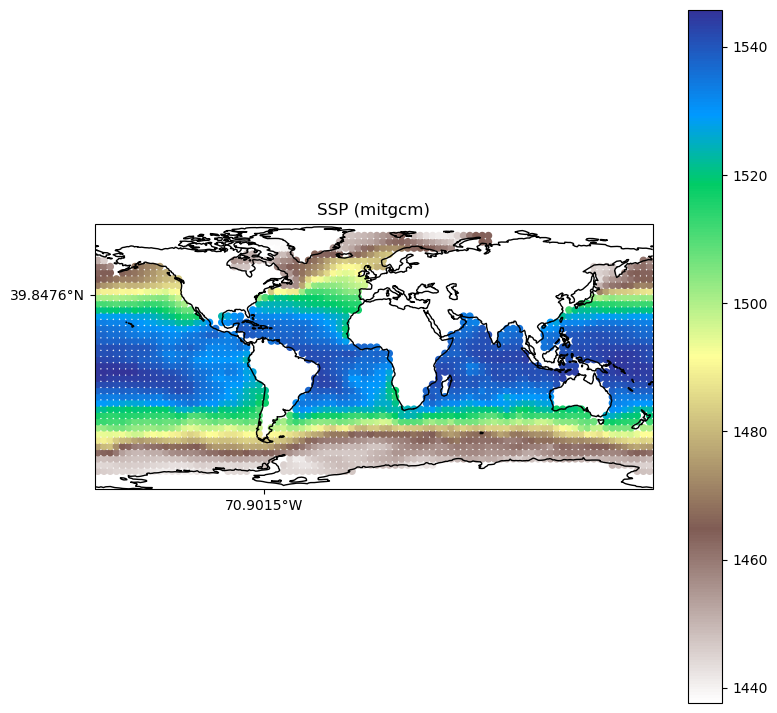

In [11]:
fig = plt.figure(figsize=(9, 9))
lon_formatter = cartopy.mpl.ticker.LongitudeFormatter(
    zero_direction_label=True)
lat_formatter = cartopy.mpl.ticker.LatitudeFormatter()

ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
im=ax.scatter(xc,
              yc,
              c=ds.ihop_ssp,
              cmap='terrain_r',
              s=20,
              transform=cartopy.crs.PlateCarree())
ax.coastlines()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(line[0][0], line[0][-1], 10.0))
ax.set_yticks(np.arange(line[1][0], line[1][-1], 10.0))
ax.set_title('SSP (mitgcm)')

#im.set_clim(min(rbf_ssp), max(idw_ssp))
plt.colorbar(im)

values of interp aren't even close to the values of ssp in the ocean. Off by an order of magnitude!

# Example filling NaNs and interpolating using IDW

Using [this example](https://pangeo-pyinterp.readthedocs.io/en/latest/auto_examples/ex_fill_undef.html#gauss-seidel) to interpolate even with NaNs. Feels like a hack, so I want to take this interp, and find the indices of each point used in the interpolation. Not sure how to do this yet

In [12]:
from pyinterp import tests, backends, fill
from pyinterp.backends import xarray

In [13]:
ds = tests.load_grid2d()
dsNESBA = ds.sel( lat=slice(39, 40), lon=slice(sb.lon180to360(-71), sb.lon180to360(-70)) )

In [14]:
ds

<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 712)
Coordinates:
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 -89.0 -88.75 -88.5 -88.25 ... 88.0 88.25 88.5 88.75
Data variables:
    mss      (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    title:          Mean Sea Surface
    institution:    CNES CLS
    Conventions:    CF-1.6
    cdm_data_type:  Grid
    version:        2.0

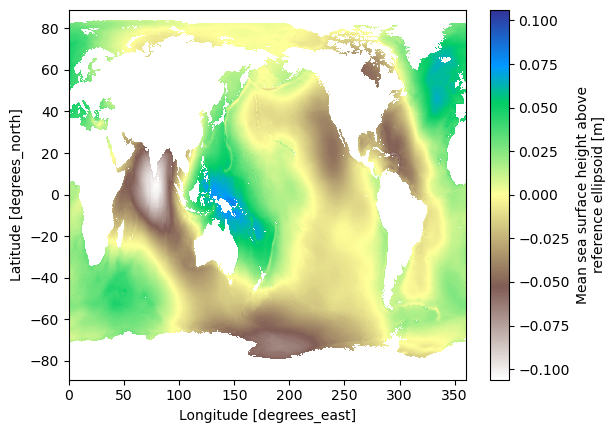

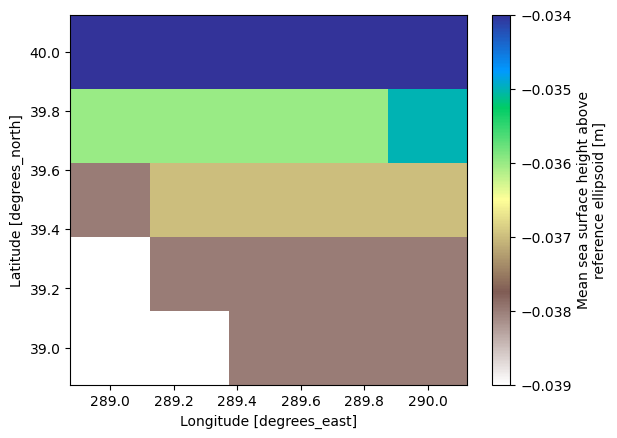

In [15]:
ds.mss.plot(cmap = 'terrain_r')

plt.figure()
dsNESBA.mss.plot(cmap='terrain_r')

### Fill NanNs 🙄

In [16]:
grid = xarray.Grid2D(ds.mss)
filled = pyinterp.fill.loess(grid, nx=3, ny=3)

In [17]:
x , y = np.meshgrid(ds.lon, ds.lat)

In [18]:
filled_mesh = pyinterp.RTree()
filled_mesh.packing(np.vstack((x.ravel(), y.ravel())).T, filled.T.ravel())

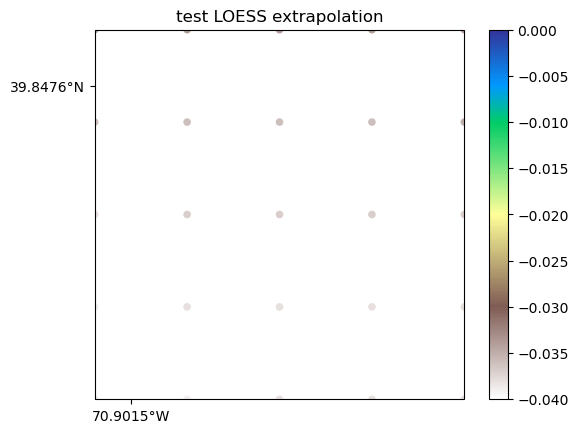

In [19]:
fig = plt.figure()
lon_formatter = cartopy.mpl.ticker.LongitudeFormatter(
    zero_direction_label=True)
lat_formatter = cartopy.mpl.ticker.LatitudeFormatter()

ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
im=ax.scatter(x,
              y,
              c=filled.T,
              cmap='terrain_r',
              s=20,
              transform=cartopy.crs.PlateCarree())
ax.coastlines()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(line[0][0], line[0][-1], 10.0))
ax.set_yticks(np.arange(line[1][0], line[1][-1], 10.0))
ax.set_title('test LOESS extrapolation')
ax.set_extent([-71, -70, 39, 40])

im.set_clim(-.04, 0)
plt.colorbar(im)

### calc coord distances to the first point

for a point of **line**

In [86]:
def nearestIndices(ds, k=4):
    # for all points
    TOL = 1e-1
    lonN, latN = np.meshgrid(ds.lon, ds.lat)
    idList = []

    for lon, lat in zip(line[0], line[1]):
        lon = sb.lon180to360(lon)

        lons, lats = np.meshgrid(np.ones(len(ds.lon)) * lon,
                                 np.ones(len(ds.lat)) * lat )

        distquery = filled_mesh.query(np.array([[lon,lat]]), k=k)
        distquery = distquery[0][0]

        distances = pyinterp.geodetic.coordinate_distances( lons.ravel(), lats.ravel(), 
                                                            lonN.ravel(), latN.ravel(),
                                                            strategy='vincenty')
    #    distancesreshaped = distances.reshape(lonN.shape)
        idLat = []; idLon = []
        for dist in distquery:
            for d in range(len(distances)):
                if abs(dist - distances[d]) < TOL:
                    (i,j) = np.unravel_index(d, lonN.shape)
                    idLat.append(i)
                    idLon.append(j)
                    
        idList.append([idLon, idLat])
    return idList

In [87]:
idList = nearestIndices(dsNESBA)

(array([[13732.53080792, 16900.37881638, 18905.36266568, 21309.656414  ]]), array([[-0.036, -0.036, -0.034, -0.034]]))
(array([[15431.96714242, 17296.29332132, 18049.85374986, 19659.49430093]]), array([[-0.036, -0.034, -0.036, -0.034]]))
(array([[15765.3863204 , 17185.61727646, 18070.04664313, 19328.948554  ]]), array([[-0.034, -0.036, -0.034, -0.036]]))
(array([[14337.70106468, 16558.80643912, 18978.45860076, 20713.66445271]]), array([[-0.034, -0.034, -0.036, -0.036]]))
(array([[13047.16692157, 15149.1972102 , 20800.35943997, 22184.23187149]]), array([[-0.034, -0.034, -0.036, -0.036]]))
(array([[11938.34526829, 13872.23508218, 22644.30657477, 23724.6916156 ]]), array([[-0.034, -0.034, -0.036, -0.036]]))
(array([[11065.99492281, 12767.78228075, 24505.32361681, 25322.2912464 ]]), array([[-0.034, -0.034, -0.036, -0.036]]))


[[[0, 1, 0, 1], [3, 3, 4, 4]],
 [[0, 0, 1, 1], [3, 4, 3, 4]],
 [[0, 0, 1, 1], [4, 3, 4, 3]],
 [[0, 1, 0, 1], [4, 4, 3, 3]],
 [[0, 1, 0, 1], [4, 4, 3, 3]],
 [[0, 1, 0, 1], [4, 4, 3, 3]],
 [[0, 1, 0, 1], [4, 4, 3, 3]]]

# Copy of IDW algo in RTree

In [30]:
def calc_idw(dist, values):
    ww = sum(1/dist**2)
    u = 0
    for ii in range(len(dist)):
        u = u + values[ii]/dist[ii]**2/ww
    return u